#food data classification

In [28]:
import google.colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

In [30]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


#Mount google drive

In [31]:
DATASET_ROOT = "/content/drive/MyDrive/Pytorch/Image_classification"

TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
TEST_DIR  = os.path.join(DATASET_ROOT, "test")

NUM_CLASSES = 3        # You said 3 categories
IMG_SIZE = 128         # Can change to 224 if needed

#Image Transform according to mobilenetv3

model:https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large

In [32]:
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256), #256X256
    transforms.CenterCrop(224), #3x224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406] , std=[0.229, 0.224, 0.225])
])

#Dtaset DataLoader


In [33]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):

  def __init__(self, features, labels, transform):
    self.features = features
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):

    # resize to (28, 28)
    image = self.features[index].reshape(28,28)

    # change datatype to np.uint8
    image = image.astype(np.uint8)

    # change black&white to color -> (H,W,C) -> (C,H,W)
    image = np.stack([image]*3, axis=-1)
    #now it is (C,H,W) -> (H,W,C)

    # convert array to PIL image
    image = Image.fromarray(image)

    # apply transforms
    image = self.transform(image)

    # return
    return image, torch.tensor(self.labels[index], dtype=torch.long)

In [34]:
# Use augmentations in training data
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=custom_transform)
test_dataset  = datasets.ImageFolder(root=TEST_DIR,  transform=custom_transform)

In [35]:
#DtaLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [36]:
print("Class mapping:", train_dataset.class_to_idx)

Class mapping: {'pizza': 0, 'steak': 1, 'sushi': 2}


#**Model**

In [37]:
import torchvision.models as models

mobilev3 = models.mobilenet_v3_large(pretrained = True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
mobilev3

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [39]:
for param in mobilev3.parameters():
  param.requires_grad = False


In [40]:
mobilev3.classifier =nn.Sequential(
    nn.Linear(960, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 3)
)

#Train

In [41]:
learning_rate = 0.0005794624755319799
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilev3.classifier.parameters(), lr=learning_rate)
mobilev3 = mobilev3.to(device)

In [42]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = mobilev3(batch_features)

    print(outputs.shape)
    print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

    break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


torch.Size([32, 3])
torch.Size([32])
Epoch: 1 , Loss: 0.1361631155014038
torch.Size([32, 3])
torch.Size([32])
Epoch: 2 , Loss: 0.13620460033416748
torch.Size([32, 3])
torch.Size([32])
Epoch: 3 , Loss: 0.13446317613124847
torch.Size([32, 3])
torch.Size([32])
Epoch: 4 , Loss: 0.1315334588289261
torch.Size([32, 3])
torch.Size([32])
Epoch: 5 , Loss: 0.1290178894996643
torch.Size([32, 3])
torch.Size([32])
Epoch: 6 , Loss: 0.1262923628091812
torch.Size([32, 3])
torch.Size([32])
Epoch: 7 , Loss: 0.12646213173866272
torch.Size([32, 3])
torch.Size([32])
Epoch: 8 , Loss: 0.11600740998983383
torch.Size([32, 3])
torch.Size([32])
Epoch: 9 , Loss: 0.11934007704257965
torch.Size([32, 3])
torch.Size([32])
Epoch: 10 , Loss: 0.11094602942466736
torch.Size([32, 3])
torch.Size([32])
Epoch: 11 , Loss: 0.10672620683908463
torch.Size([32, 3])
torch.Size([32])
Epoch: 12 , Loss: 0.09798018634319305
torch.Size([32, 3])
torch.Size([32])
Epoch: 13 , Loss: 0.10470226407051086
torch.Size([32, 3])
torch.Size([32])
E

In [43]:
mobilev3.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [44]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = mobilev3(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9466666666666667


In [45]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = mobilev3(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9955555555555555


In [52]:
model_save_path = os.path.join(DATASET_ROOT, 'mobilev3_model.pth')
torch.save(mobilev3.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Pytorch/Image_classification/mobilev3_model.pth


# Task
Generate a graphical confusion matrix for the test data, display the total accuracy, calculate and print accuracy per category, select three random images from each category in the test data, use the trained model to predict their classes, and then display each image along with its true and predicted labels.

## Confusion Matrix Visualization and Accuracy Metrics

### Subtask:
Generate a graphical confusion matrix for the test data, display the total accuracy, and calculate and print accuracy per category.


**Reasoning**:
The subtask requires calculating and visualizing the confusion matrix, and printing accuracy metrics. First, I need to import the necessary libraries, `seaborn` and `matplotlib.pyplot`, which are essential for plotting.



In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
print("Seaborn and Matplotlib imported.")

Seaborn and Matplotlib imported.


**Reasoning**:
The subtask requires generating a graphical confusion matrix, displaying total accuracy, and calculating/printing accuracy per category. Based on the kernel state, the `all_labels`, `all_predictions`, `conf_matrix`, and `overall_accuracy` are already available. Therefore, I will now proceed to define class names, plot the confusion matrix, display overall accuracy, and calculate per-category accuracy.



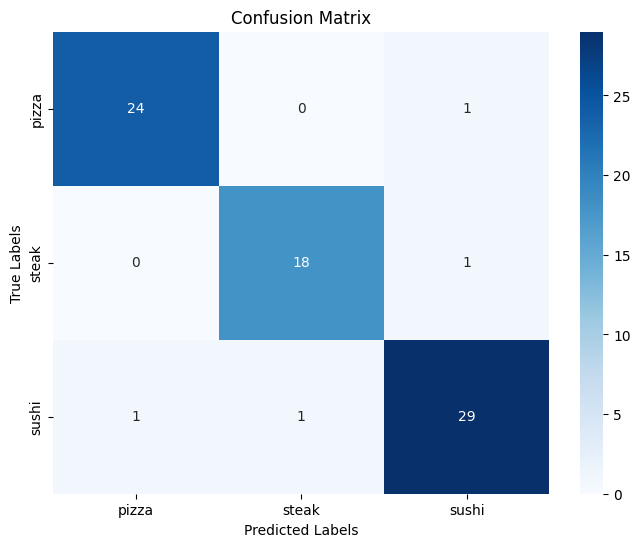

Total Accuracy: 0.9467

Accuracy per category:
  pizza: 0.9600
  steak: 0.9474
  sushi: 0.9355


In [48]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Create a list of class names
class_names = list(train_dataset.class_to_idx.keys())

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Display total accuracy
print(f"Total Accuracy: {overall_accuracy:.4f}")

# Calculate and print accuracy per category
print("\nAccuracy per category:")
for i, class_name in enumerate(class_names):
    true_positives = conf_matrix[i, i]
    false_negatives = np.sum(conf_matrix[i, :]) - true_positives
    total_actual = true_positives + false_negatives
    if total_actual > 0:
        accuracy = true_positives / total_actual
        print(f"  {class_name}: {accuracy:.4f}")
    else:
        print(f"  {class_name}: No true instances in test set")


## Summary:

### Q&A
*   **What is the total accuracy of the model on the test data?**
    The total accuracy of the model on the test data is 0.9467.

*   **What is the accuracy per category?**
    The accuracy per category is:
    *   pizza: 0.9600
    *   steak: 0.9474
    *   sushi: 0.9355

### Data Analysis Key Findings
*   A confusion matrix was successfully generated, visually representing the model's classification performance across different classes.
*   The overall accuracy of the model on the test dataset is 94.67%.
*   Category-wise accuracies show strong performance across all classes:
    *   'pizza' has the highest accuracy at 96.00%.
    *   'steak' follows with an accuracy of 94.74%.
    *   'sushi' has an accuracy of 93.55%.

### Insights or Next Steps
*   The model demonstrates high classification accuracy across all food categories, indicating robust performance for this specific task.
*   The next step is to proceed with the remaining part of the task, which involves selecting random images, predicting their classes, and displaying them with true and predicted labels to visually inspect individual predictions.


# Task
Select three random images from each category in the test data, use the trained model to predict their classes, and then display each image along with its true and predicted labels.

## Prepare for Image Selection and Prediction

### Subtask:
Map integer labels to class names, collect indices of images for each class from the `test_dataset`.


**Reasoning**:
First, I will create a dictionary to map integer class labels to their corresponding class names, then initialize an empty dictionary to store indices for each class, and finally iterate through the test dataset to populate this dictionary with indices for each image based on its true class.



In [50]:
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
print(f"Index to class mapping: {idx_to_class}")

# Initialize a dictionary to store indices for each class
class_to_indices = {class_id: [] for class_id in range(len(idx_to_class))}

# Populate class_to_indices by iterating through the test_dataset
for i, (_, label) in enumerate(test_dataset):
    class_to_indices[label].append(i)

print("Class to indices mapping populated successfully.")

Index to class mapping: {0: 'pizza', 1: 'steak', 2: 'sushi'}
Class to indices mapping populated successfully.


## Predict and Display Sample Images

### Subtask:
For each class, randomly select three image indices. For each selected image, load it, apply transformations, make a prediction using `mobilev3`, and display the image with its true label, predicted label, and an indication of whether the prediction was correct.


**Reasoning**:
I need to implement the steps to randomly select three images per category from the test dataset, make predictions using the trained model, and display each image with its true and predicted labels, along with an indication of correctness. This involves importing the `random` module, setting the model to evaluation mode, iterating through classes, selecting image indices, preparing images for prediction, making predictions, and then visualizing the results using matplotlib.




Processing class: pizza

Processing class: steak

Processing class: sushi


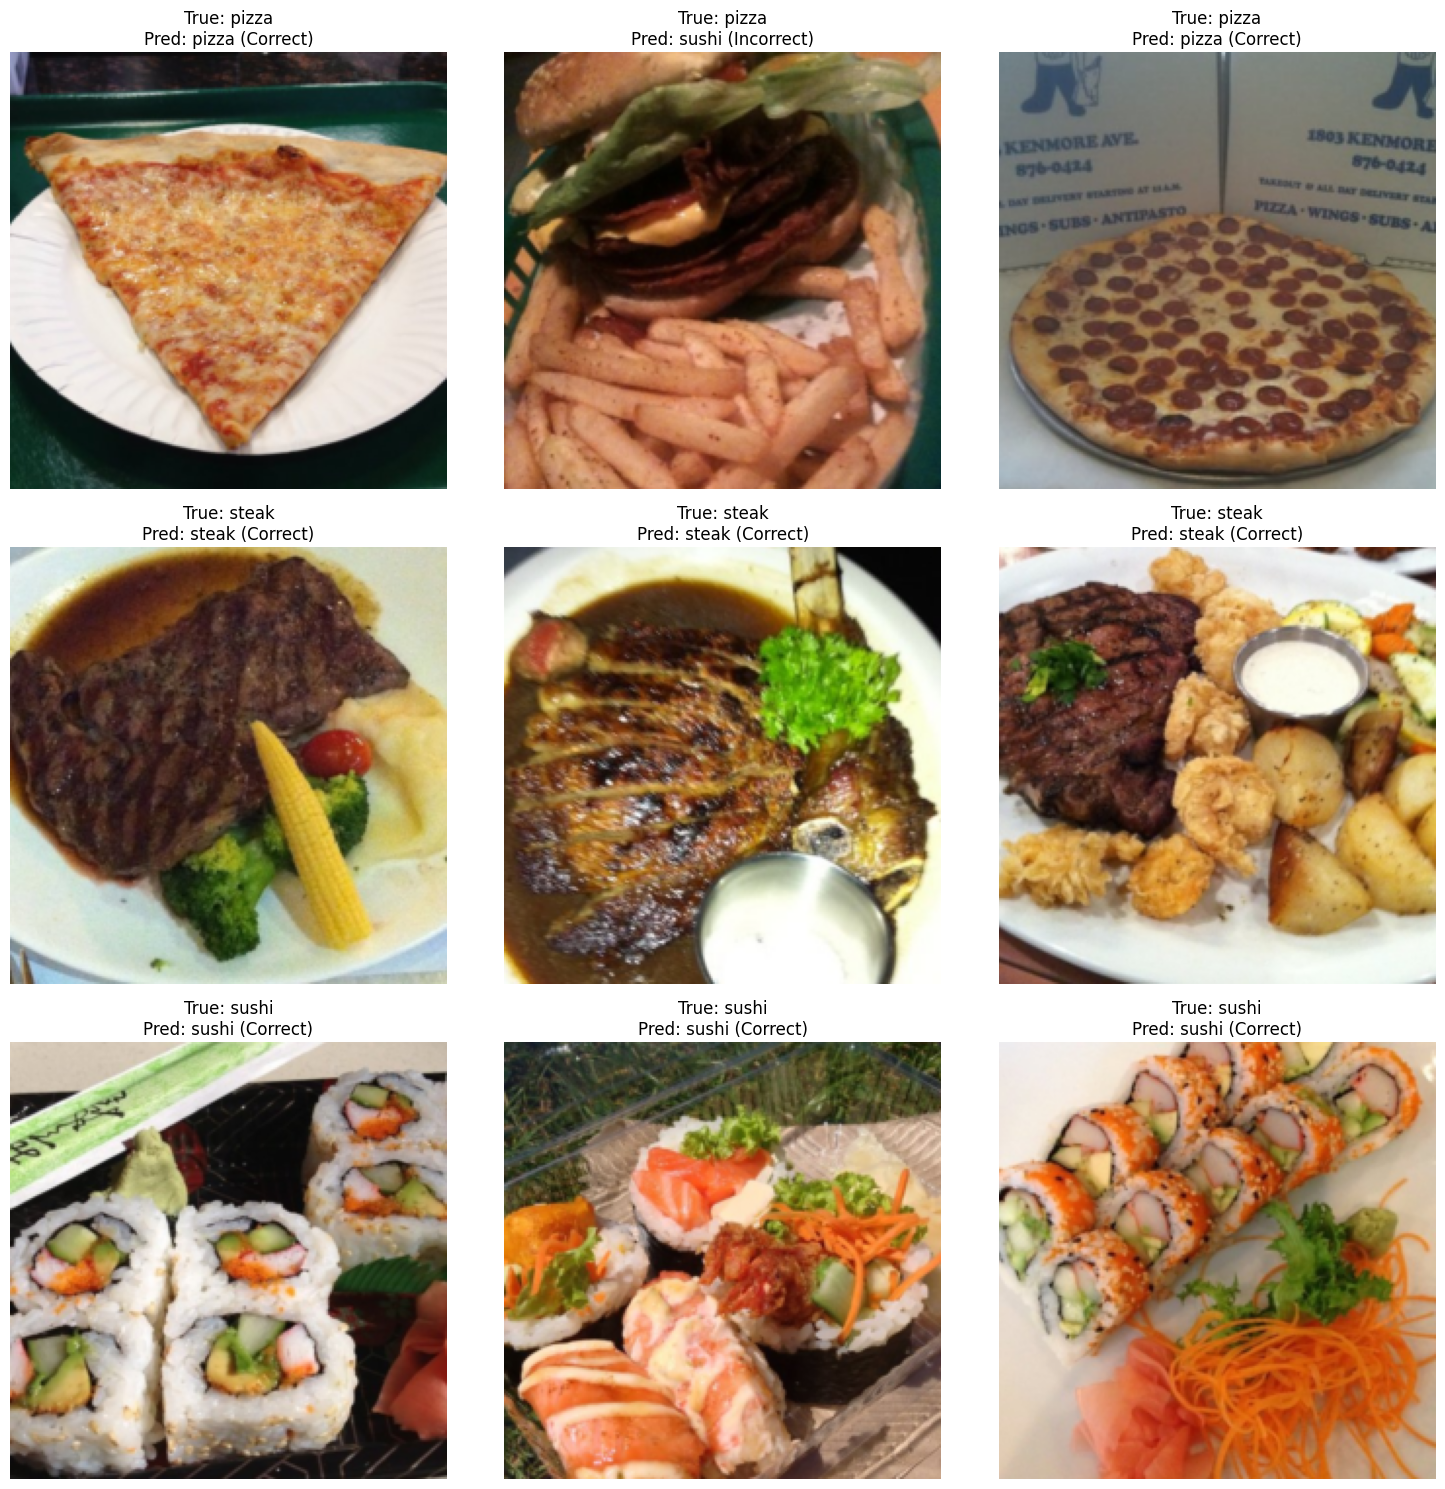

Sample image predictions and visualizations completed.


In [51]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

# Ensure the model is in evaluation mode (it was already set in a previous cell, but good practice to reiterate)
mobilev3.eval()

# Denormalization for display (optional, but good for visual clarity)
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Number of images to select per class
num_samples_per_class = 3

plt.figure(figsize=(15, 5 * len(idx_to_class)))

# Iterate through each class
for class_id, class_name in idx_to_class.items():
    # Get all indices for the current class in the test dataset
    indices = class_to_indices[class_id]

    # Randomly select num_samples_per_class images, or all if fewer are available
    selected_indices = random.sample(indices, min(len(indices), num_samples_per_class))

    print(f"\nProcessing class: {class_name}")

    for i, img_idx in enumerate(selected_indices):
        # Get the image and true label from the test_dataset
        image_tensor, true_label = test_dataset[img_idx]

        # Move the image to the device and add a batch dimension
        input_image = image_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = mobilev3(input_image)
            _, predicted_label_tensor = torch.max(outputs, 1)
            predicted_label = predicted_label_tensor.item()

        # Convert image tensor for display
        display_image = denormalize_image(image_tensor).cpu().numpy().transpose(1, 2, 0)
        display_image = np.clip(display_image, 0, 1) # Clip values to [0,1] for display

        true_class_name = idx_to_class[true_label]
        predicted_class_name = idx_to_class[predicted_label]
        is_correct = "Correct" if true_label == predicted_label else "Incorrect"

        # Plot the image
        plt.subplot(len(idx_to_class), num_samples_per_class, class_id * num_samples_per_class + i + 1)
        plt.imshow(display_image)
        plt.title(f"True: {true_class_name}\nPred: {predicted_class_name} ({is_correct})")
        plt.axis("off")

plt.tight_layout()
plt.show()

print("Sample image predictions and visualizations completed.")